# Spoken Digit Recognition

Firstly import needed libraries:

In [1]:
!pip3 show seaborn
try:
    # Wavfile libraries
    from scipy.io.wavfile import read
    from librosa import get_duration
    # ML libraries
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # FFT libs
    from scipy.fft import fft, ifft, fftfreq
    # Own libs
    from utils import *
    # Other
    import os
    import re
    import seaborn as sb
except:
    print("\n\nSomething is wrong\n\n")

Name: seaborn
Version: 0.12.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /home/krystian/anaconda3/envs/conda-env/lib/python3.8/site-packages
Requires: matplotlib, numpy, pandas
Required-by: 


2023-02-20 18:09:27.799018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 18:09:27.893793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 18:09:27.893808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 18:09:27.913337: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-20 18:09:28.454817: W tensorflow/stream_executor/platform/de

Some functions to not duplicate code:

In [2]:
# Fast plotting
def plot_signal(X, Y, xlabel, ylabel, title):
    plt.figure()
    plt.plot(X, Y)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

Then dataset should be downloaded (source: https://github.com/TaskAccount/free-spoken-digit-dataset/tree/master/recordings). GlobalVariables is class created to make it easier to store significant data:

In [3]:

# ---------------------------------------------------------------------------------
# Read all recordings
records_dir = os.path.dirname(os.path.realpath('__file__')) + '/recordings/'
GlobVar = GlobalVariables()
save_or_load_csv = 1
LABEL_NUMBER = 5

if save_or_load_csv == 1:
    for wavfile in os.listdir(records_dir):
        number = int(wavfile[0])
        number_vec = np.zeros(LABEL_NUMBER)
        number_vec[number] = 1
        name, sample_id = re.findall(r'_(.*)_(.*).wav', wavfile)[0]
        signal = np.array(read(records_dir + wavfile)[1], dtype=float)
        f, y_signal = read(records_dir + wavfile)


        if GlobVar.MAX_SAMPLES < signal.shape[0]:
            GlobVar.MAX_SAMPLES = signal.shape[0]
        if GlobVar.MAX_VALUE < np.max(signal):
            GlobVar.MAX_VALUE = np.max(signal)
        if GlobVar.MIN_SAMPLES > signal.shape[0]:
            GlobVar.MIN_SAMPLES = signal.shape[0]

        data = {
            "id": sample_id,
            "name": name,
            "duration": float(get_duration(filename=records_dir + wavfile)),
            "signal": [signal],
            "signal_shape": signal.shape,
            "number_vec": [number_vec.tolist()],
            "number": [number]
        }

        GlobVar.all_records.append(data)
        GlobVar.df_records = pd.concat(
            [GlobVar.df_records, pd.DataFrame(data)], ignore_index=True, axis=0)
        GlobVar.sorted_records[number].append(signal)

    for index, sig in enumerate(GlobVar.df_records["signal"]):
        zero_vec = np.zeros(GlobVar.MAX_SAMPLES)
        zero_vec[0:sig.shape[0]] = sig/GlobVar.MAX_VALUE
        GlobVar.df_records["signal"][index] = zero_vec.tolist()
        GlobVar.df_records["signal_shape"][index] = zero_vec.shape[0]
        GlobVar.all_records[index] = zero_vec.tolist()
        GlobVar.sorted_records[GlobVar.df_records["number"][index]] = zero_vec.tolist()

    # GlobVar.df_records.to_parquet('dataframe.parquet')
if save_or_load_csv == 2:
    GlobVar.df_records = pd.read_parquet('dataframe.parquet')

y_fft_list = []
x_fft_list = []
for signal in GlobVar.df_records["signal"]:
    T = 1.0/f
    N = len(signal)
    N_fft = N//2
    y_fft = fft(signal,2**14)
    y_fft = np.abs(y_fft)
    y_fft = y_fft[0:N_fft]
    y_fft = y_fft/y_fft.max()
    x_fft = fftfreq(N, T)[:N_fft]
    y_fft_list.append(y_fft)
    x_fft_list.append(x_fft)
    if False:    
        plot_signal(x_fft, np.abs(y_fft[:N_fft]), "Frequency [Hz]",
                    "Amplitude", f"Number {number} of person {name}")
        plt.show()

GlobVar.df_records.insert(loc=len(GlobVar.df_records.columns), column="y_fft", value=y_fft_list)
GlobVar.df_records.insert(loc=len(GlobVar.df_records.columns), column="x_fft", value=x_fft_list)

df_train, df_test = train_test_split(GlobVar.df_records, train_size=0.75)

/tmp/ipykernel_14294/3219922721.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GlobVar.df_records["signal"][index] = zero_vec.tolist()
/tmp/ipykernel_14294/3219922721.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GlobVar.df_records["signal_shape"][index] = zero_vec.shape[0]


Our DataFrame object looks as follow:

In [4]:
GlobVar.df_records.head()

,id,name,duration,signal,signal_shape,number_vec,number,y_fft,x_fft
0,48,lucas,0.745875,"[-0.0004989486439288641, 0.0005702270216329876...",10504,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,"[0.0004569215912878094, 0.0005132062429625317,...","[0.0, 0.7616146230007617, 1.5232292460015233, ..."
1,14,theo,0.247000,"[-0.0008553405324494814, -0.000997897287857728...",10504,"[0.0, 1.0, 0.0, 0.0, 0.0]",1,"[0.008229033748731351, 0.00836463983882965, 0....","[0.0, 0.7616146230007617, 1.5232292460015233, ..."
2,24,jackson,0.522500,"[-0.018924409280444778, -0.000784062154745358,...",10504,"[0.0, 0.0, 1.0, 0.0, 0.0]",2,"[0.0004293666769113728, 0.0003052477303523035,...","[0.0, 0.7616146230007617, 1.5232292460015233, ..."
3,23,george,0.367500,"[-0.0025660215973484445, -0.003243166185537617...",10504,"[0.0, 1.0, 0.0, 0.0, 0.0]",1,"[0.0016027004768143424, 0.0015479752199825962,...","[0.0, 0.7616146230007617, 1.5232292460015233, ..."
4,41,lucas,0.554250,"[-0.0012473716098221604, 0.0037421148294664816...",10504,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,"[0.0007829354427421963, 0.0008894177438707432,...","[0.0, 0.7616146230007617, 1.5232292460015233, ..."


The most important informations for us is the signal (array of the samples), y_fft which are our signals in frequency-domain and number/number_vec which describes our labels (presented as an exact number and one-hot-encoding version).

Because of the fact that time-domain signal is not sufficient to use it as an input for our model we need to use frequency-domain signal. But there is no trade-off for number of signal dimensions and number of samples. That is why I decided to apply dimensional reduction method - PCA (Principal Component analysis):

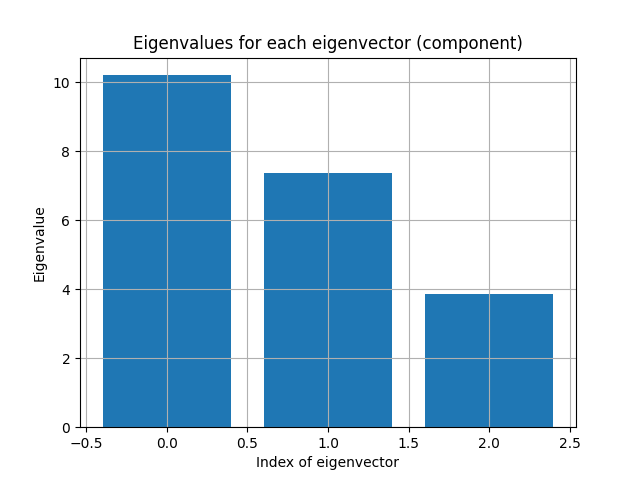

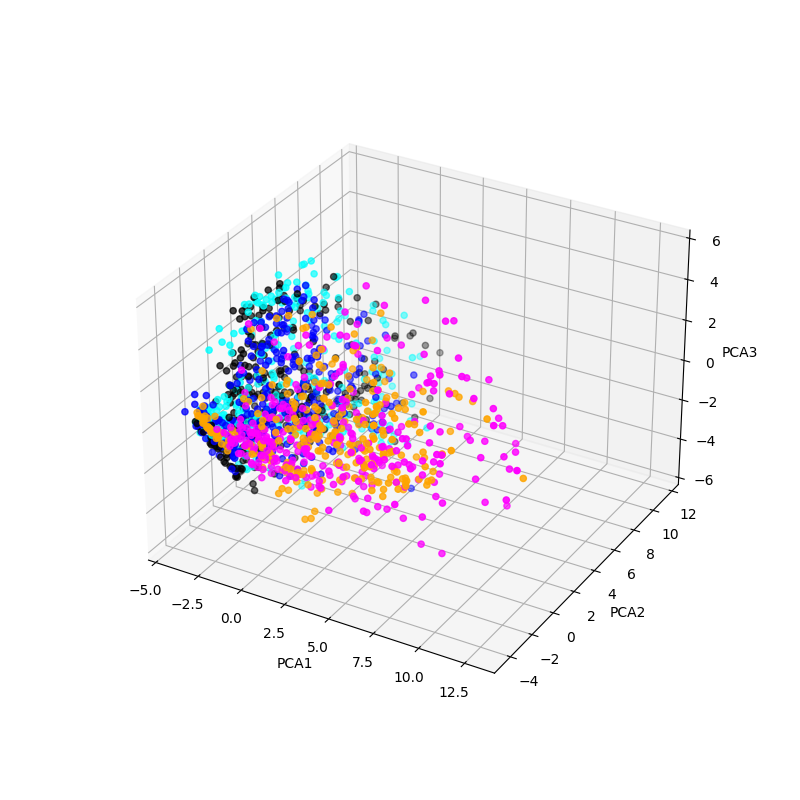

In [5]:
# ---------------------------------------------------------------------------------
# PCA
%matplotlib widget
J = 3
pca = PCA(n_components= J)

X_pca_fft = GlobVar.df_records["y_fft"].tolist()
check_me = pca.fit(X_pca_fft)
var = check_me.explained_variance_
indices = [each for each in range(var.size)]
plt.figure()
plt.bar(indices, height=var)
plt.grid()
plt.xlabel("Index of eigenvector")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues for each eigenvector (component)")
plt.show()

train_pca = pca.transform(X_pca_fft)

keys = {}
for i in range(J):
    ii = i+1
    keys[str(ii)] = train_pca[:, i]

train_pca = pd.DataFrame(keys)
# train_pca = pd.DataFrame({'First': train_pca[:, 0], 'Second': train_pca[:, 1], 'Third': train_pca[:, 2]})

train_pca = train_pca.join(GlobVar.df_records["number_vec"])
train_pca = train_pca.join(GlobVar.df_records["number"])

if J == 3:
    colors = {0:'blue', 1:'magenta', 2:'black', 3:'cyan', 4:'orange', 5:'green', 6:'red', 7:'purple', 8:'brown', 9:'pink'}

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(train_pca['1'], train_pca['2'], train_pca['3'], c=train_pca['number'].map(colors))

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.show()

As we can see our data with NxF dimensions (N - number of samples and F number of each frequency) has been reduced to matrix NxJ (where J is number of PCA components). Eigenvalues for those components are relatively high so let's consider greater amount of them:

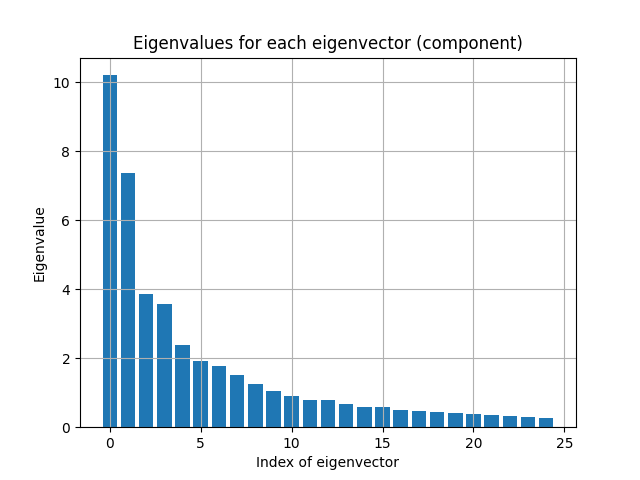

In [6]:
# ---------------------------------------------------------------------------------
# PCA
J = 25
pca = PCA(n_components= J)

X_pca_fft = GlobVar.df_records["y_fft"].tolist()
check_me = pca.fit(X_pca_fft)
var = check_me.explained_variance_
indices = [each for each in range(var.size)]
plt.figure()
plt.bar(indices, height=var)
plt.grid()
plt.xlabel("Index of eigenvector")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues for each eigenvector (component)")
plt.show()

train_pca = pca.transform(X_pca_fft)

keys = {}
for i in range(J):
    ii = i+1
    keys[str(ii)] = train_pca[:, i]

train_pca = pd.DataFrame(keys)

train_pca = train_pca.join(GlobVar.df_records["number_vec"])
train_pca = train_pca.join(GlobVar.df_records["number"])

if J == 3:
    colors = {0:'blue', 1:'magenta', 2:'black', 3:'cyan', 4:'orange', 5:'green', 6:'red', 7:'purple', 8:'brown', 9:'pink'}

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(train_pca['1'], train_pca['2'], train_pca['3'], c=train_pca['number'].map(colors))

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.show()

Here we can notice that the eigenvalues for eigenvectors of indices 20 and more are not so different. That is why we will remain this number of components.

For now we have our input data prepared. It's time to implement our recognition model.

2023-02-20 18:09:55.785157: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-20 18:09:55.785197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Lambadziara): /proc/driver/nvidia/version does not exist
2023-02-20 18:09:55.785995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
40/40 - 1s - loss: 1.6544 - accuracy: 0.1929 - val_loss: 1.6007 - val_accuracy: 0.2400 - 875ms/epoch - 22ms/step
Epoch 2/200
40/40 - 0s - loss: 1.6092 - accuracy: 0.1929 - val_loss: 1.5800 - val_accuracy: 0.2400 - 67ms/epoch - 2ms/step
Epoch 3/200
40/40 - 0s - loss: 1.5838 - accuracy: 0.1929 - val_loss: 1.5597 - val_accuracy: 0.2400 - 68ms/epoch - 2ms/step
Epoch 4/200
40/40 - 0s - loss: 1.5558 - accuracy: 0.2518 - val_loss: 1.5301 - val_accuracy: 0.3689 - 61ms/epoch - 2ms/step
Epoch 5/200
40/40 - 0s - loss: 1.5211 - accuracy: 0.4118 - val_loss: 1.4921 - val_accuracy: 0.4978 - 65ms/epoch - 2ms/step
Epoch 6/200
40/40 - 0s - loss: 1.4782 - accuracy: 0.4518 - val_loss: 1.4452 - val_accuracy: 0.5200 - 65ms/epoch - 2ms/step
Epoch 7/200
40/40 - 0s - loss: 1.4313 - accuracy: 0.4698 - val_loss: 1.3961 - val_accuracy: 0.5244 - 64ms/epoch - 2ms/step
Epoch 8/200
40/40 - 0s - loss: 1.3841 - accuracy: 0.4604 - val_loss: 1.3497 - val_accuracy: 0.5422 - 63ms/epoch - 2ms/step
Epoch 9/200
40

Epoch 68/200
40/40 - 0s - loss: 0.5512 - accuracy: 0.8039 - val_loss: 0.5740 - val_accuracy: 0.7778 - 63ms/epoch - 2ms/step
Epoch 69/200
40/40 - 0s - loss: 0.5459 - accuracy: 0.8047 - val_loss: 0.5714 - val_accuracy: 0.7778 - 65ms/epoch - 2ms/step
Epoch 70/200
40/40 - 0s - loss: 0.5416 - accuracy: 0.8063 - val_loss: 0.5648 - val_accuracy: 0.7778 - 61ms/epoch - 2ms/step
Epoch 71/200
40/40 - 0s - loss: 0.5367 - accuracy: 0.8078 - val_loss: 0.5618 - val_accuracy: 0.7822 - 61ms/epoch - 2ms/step
Epoch 72/200
40/40 - 0s - loss: 0.5315 - accuracy: 0.8125 - val_loss: 0.5596 - val_accuracy: 0.7778 - 63ms/epoch - 2ms/step
Epoch 73/200
40/40 - 0s - loss: 0.5279 - accuracy: 0.8102 - val_loss: 0.5550 - val_accuracy: 0.7867 - 62ms/epoch - 2ms/step
Epoch 74/200
40/40 - 0s - loss: 0.5227 - accuracy: 0.8071 - val_loss: 0.5525 - val_accuracy: 0.7822 - 62ms/epoch - 2ms/step
Epoch 75/200
40/40 - 0s - loss: 0.5173 - accuracy: 0.8173 - val_loss: 0.5518 - val_accuracy: 0.7778 - 66ms/epoch - 2ms/step
Epoch 76

Epoch 134/200
40/40 - 0s - loss: 0.3036 - accuracy: 0.9035 - val_loss: 0.4196 - val_accuracy: 0.8178 - 72ms/epoch - 2ms/step
Epoch 135/200
40/40 - 0s - loss: 0.2996 - accuracy: 0.8973 - val_loss: 0.4175 - val_accuracy: 0.8222 - 73ms/epoch - 2ms/step
Epoch 136/200
40/40 - 0s - loss: 0.2982 - accuracy: 0.9059 - val_loss: 0.4149 - val_accuracy: 0.8222 - 81ms/epoch - 2ms/step
Epoch 137/200
40/40 - 0s - loss: 0.2949 - accuracy: 0.9027 - val_loss: 0.4147 - val_accuracy: 0.8178 - 75ms/epoch - 2ms/step
Epoch 138/200
40/40 - 0s - loss: 0.2920 - accuracy: 0.9027 - val_loss: 0.4159 - val_accuracy: 0.8222 - 74ms/epoch - 2ms/step
Epoch 139/200
40/40 - 0s - loss: 0.2903 - accuracy: 0.9051 - val_loss: 0.4116 - val_accuracy: 0.8178 - 71ms/epoch - 2ms/step
Epoch 140/200
40/40 - 0s - loss: 0.2868 - accuracy: 0.9059 - val_loss: 0.4110 - val_accuracy: 0.8222 - 73ms/epoch - 2ms/step
Epoch 141/200
40/40 - 0s - loss: 0.2845 - accuracy: 0.9043 - val_loss: 0.4100 - val_accuracy: 0.8311 - 71ms/epoch - 2ms/step


Epoch 200/200
40/40 - 0s - loss: 0.1760 - accuracy: 0.9490 - val_loss: 0.3313 - val_accuracy: 0.8711 - 71ms/epoch - 2ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


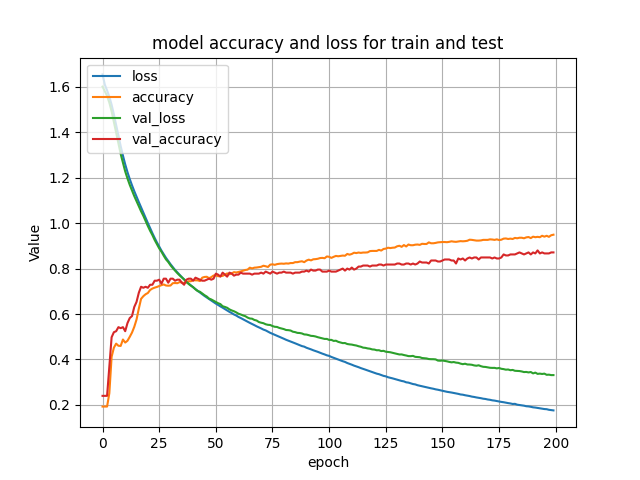

In [7]:

# ---------------------------------------------------------------------------------
# Neural Network

df_train, df_test = train_test_split(train_pca, train_size=0.85)
activ = "sigmoid"
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(J)),
    tf.keras.layers.Dense(100, activation=activ),
    tf.keras.layers.Dense(25, activation=activ),
    tf.keras.layers.Dense(8, activation=activ),
    # tf.keras.layers.Dense(4, activation=activ),
    tf.keras.layers.Dense(LABEL_NUMBER, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

X = df_train.iloc[:, [each for each in range(J)]].values.tolist()
Y = df_train["number_vec"].tolist()

X_test = df_test.iloc[:, [each for each in range(J)]].values.tolist()
Y_test = df_test["number_vec"].tolist()

save_or_load = 1
if save_or_load == 1:
    history = model.fit(x=X, y=Y, epochs=200,verbose=2, validation_data=(X_test,Y_test))
    print(history.history.keys())
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy and loss for train and test')
    plt.ylabel('Value')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy','val_loss', 'val_accuracy'], loc='upper left')
    plt.grid()
    plt.show()
    # model.save("model.h")
if save_or_load == 2:
    # model = tf.keras.models.load_model('model.h')
    pass

For now we will try to print cross-tabulation for exact and predicted digits:

8/8 [==============================] - 0s 976us/step - loss: 0.3313 - accuracy: 0.8711
[0.33130767941474915, 0.8711110949516296]
8/8 [==============================] - 0s 792us/step


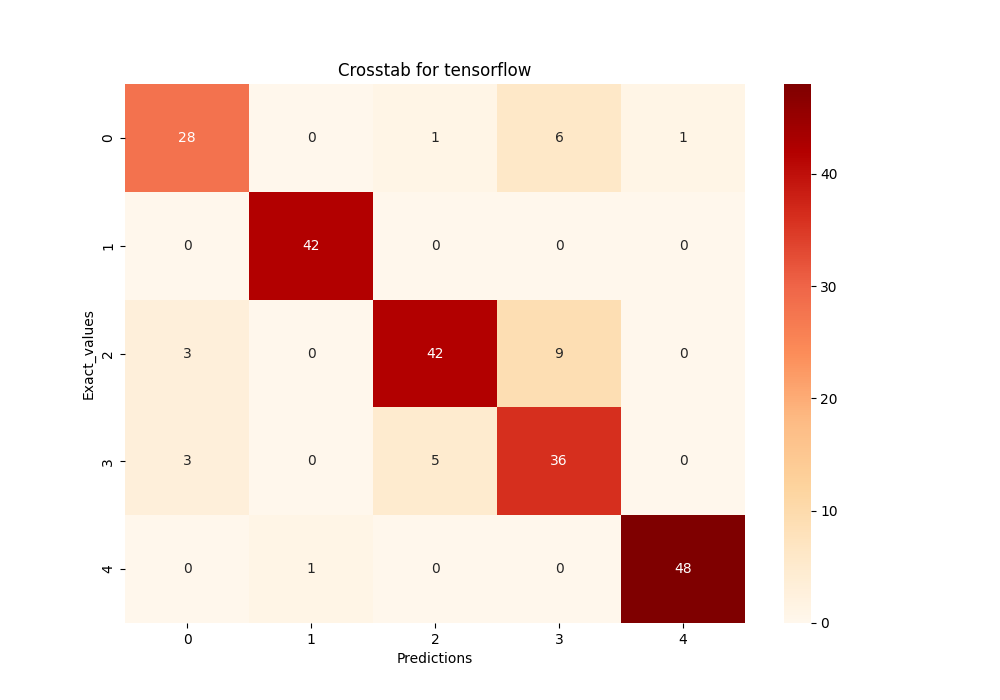

In [8]:
print(model.evaluate(X_test, Y_test))

import utils
labels = df_test["number"].tolist()

# utils.print_crosstab_terminal(X_test, Y_test, model)
utils.print_crosstab_seaborn(X_test, labels, model)


In [9]:
!jupyter nbconvert --to markdown jupyter_frequency.ipynb
# !jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook jupyter_frequency.ipynb to markdown
[NbConvertApp] Support files will be in jupyter_frequency_files/
[NbConvertApp] Making directory jupyter_frequency_files
[NbConvertApp] Making directory jupyter_frequency_files
[NbConvertApp] Making directory jupyter_frequency_files
[NbConvertApp] Making directory jupyter_frequency_files
[NbConvertApp] Making directory jupyter_frequency_files
[NbConvertApp] Writing 463524 bytes to jupyter_frequency.md
